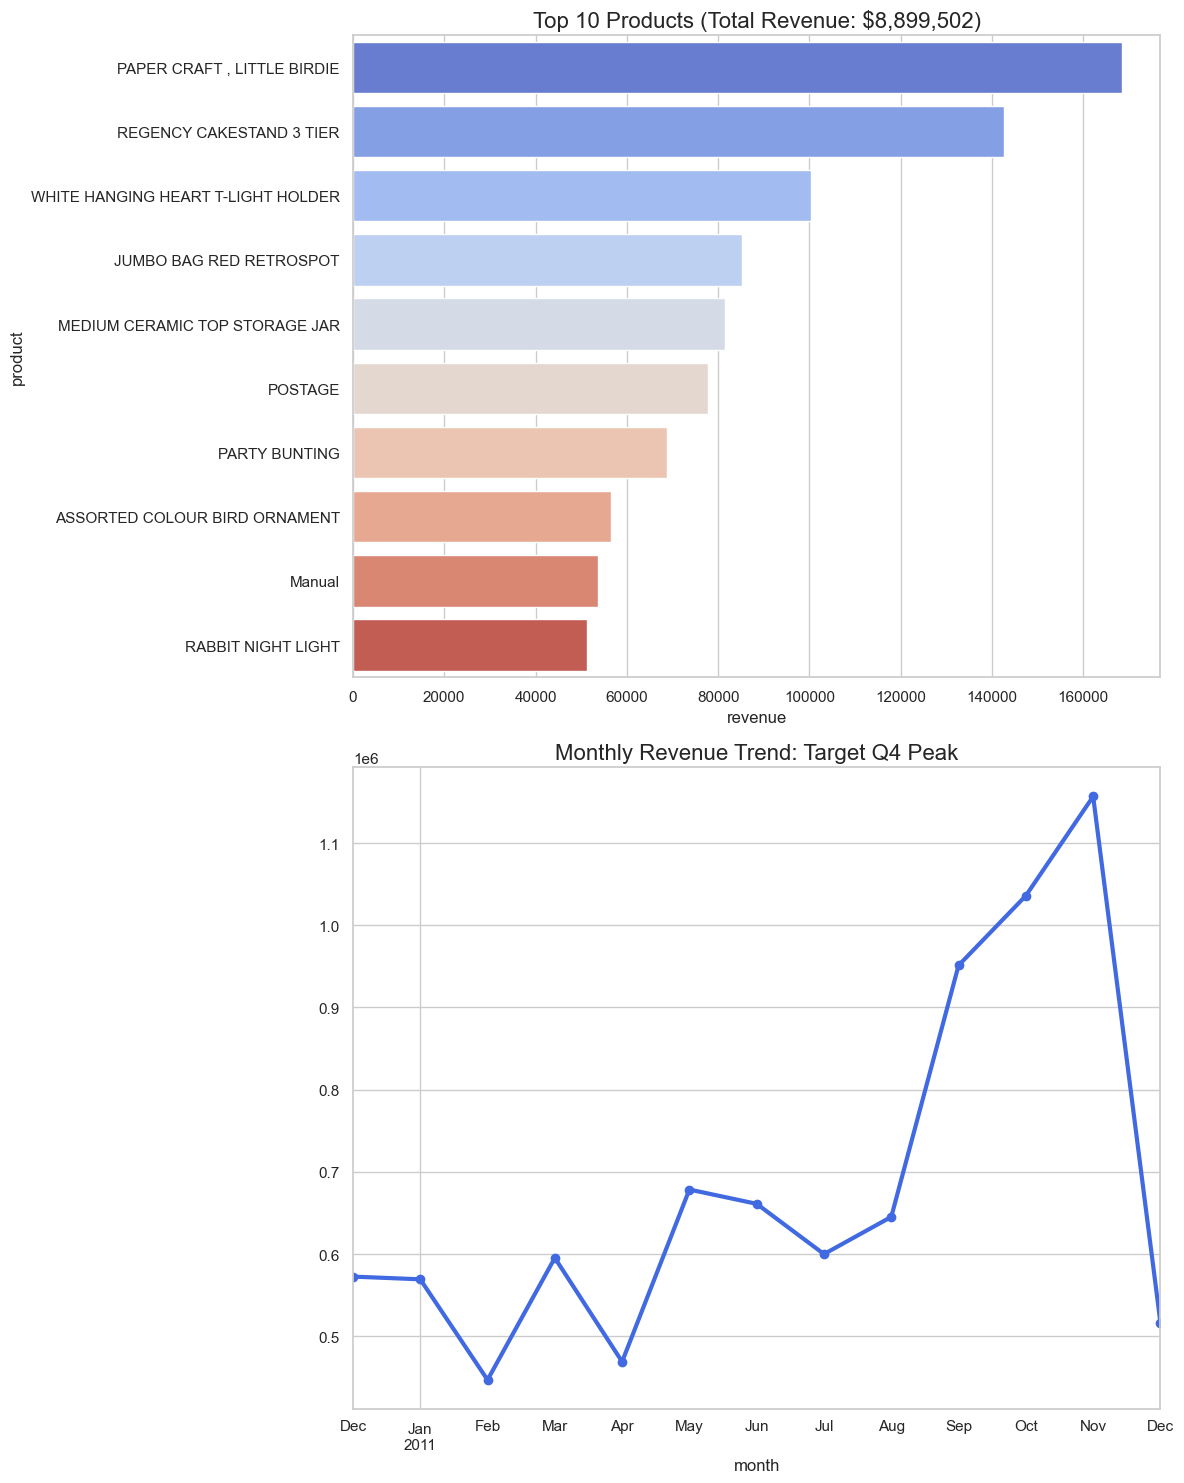

##############################
WEEK 1 BUSINESS AUDIT
##############################
Total Revenue:  $8,899,501.54
Average Order:  $480.22
Retention Rate: 65.58%
VIP Customers:  434 (Spend > $3,647)
Core Products: 810 drive 80% of sales


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. DATA AUDIT & CLEANING
df = pd.read_excel("customer.xlsx")
df = df.rename(columns={
    'InvoiceNo': 'order_id', 'CustomerID': 'customer_id',
    'InvoiceDate': 'date', 'Description': 'product',
    'Quantity': 'quantity', 'UnitPrice': 'price', 'Country': 'country'
})

# Drop noise and service fees
df = df[(df['quantity'] > 0) & (df['price'] > 0)].dropna(subset=['customer_id'])
df = df[df['product'] != 'DOTCOM POSTAGE']
df['revenue'] = df['quantity'] * df['price']

# 2. SALES & AOV METRICS (Day 2-3 logic)
total_revenue = df['revenue'].sum()
total_orders = df['order_id'].nunique()
aov = total_revenue / total_orders

# Identifying High-Value Orders (Above average)
high_value_orders = df.groupby('order_id')['revenue'].sum()
high_value_orders = high_value_orders[high_value_orders > aov]

# 3. CUSTOMER SEGMENTATION & LTV (Day 4 logic)
customer_metrics = df.groupby('customer_id').agg(
    total_spend=('revenue', 'sum'),
    total_orders=('order_id', 'nunique')
)

# VIPs: Top 10% by spend
vip_threshold = customer_metrics['total_spend'].quantile(0.9)
vips = customer_metrics[customer_metrics['total_spend'] >= vip_threshold]

# Retention
repeat_rate = (len(customer_metrics[customer_metrics['total_orders'] > 1]) / len(customer_metrics)) * 100

# 4. PARETO PRODUCT ANALYSIS (Day 5-6 logic)
product_metrics = df.groupby('product')['revenue'].sum().sort_values(ascending=False).to_frame()
product_metrics['revenue_share'] = product_metrics['revenue'] / total_revenue
product_metrics['cumulative_share'] = product_metrics['revenue_share'].cumsum()
core_products = product_metrics[product_metrics['cumulative_share'] <= 0.8]

# 5. FINAL VISUALIZATION
sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(2, 1, figsize=(12, 15))

# Top 10 Products
top_10 = product_metrics.head(10)
sns.barplot(ax=axes[0], x=top_10['revenue'], y=top_10.index, hue=top_10.index, palette="coolwarm", legend=False)
axes[0].set_title(f'Top 10 Products (Total Revenue: ${total_revenue:,.0f})', fontsize=16)

# Seasonality
df['month'] = df['date'].dt.to_period('M')
df.groupby('month')['revenue'].sum().plot(kind='line', ax=axes[1], marker='o', color='royalblue', linewidth=3)
axes[1].set_title('Monthly Revenue Trend: Target Q4 Peak', fontsize=16)

plt.tight_layout()
plt.show()

# --- PRINT FINAL AUDIT ---
print(f"{'#'*30}\nWEEK 1 BUSINESS AUDIT\n{'#'*30}")
print(f"Total Revenue:  ${total_revenue:,.2f}")
print(f"Average Order:  ${aov:.2f}")
print(f"Retention Rate: {repeat_rate:.2f}%")
print(f"VIP Customers:  {len(vips)} (Spend > ${vip_threshold:,.0f})")
print(f"Core Products: {len(core_products)} drive 80% of sales")